# Modeling: The Clogging Problem

## Problem setup

Imports

In [1]:
import math
import random
import numpy as np
import numpy.linalg as linalg
from scipy import interpolate
from scipy.integrate import ode

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
from IPython.display import HTML #needed to view animations in Jupyter

Constants

In [2]:
#===Pipe system===
# len_m = 300 * 10 **(-6) #radius of pipe at mouth (m) microns
# len_c = 30 * 10 ** (-6) #radius of pipe at constriction (m)
# length = 300 * 10 ** (-6) #length of pipe
# scalef = 2 * 10**8 #scaling factor between the actual radius and the graphed radius
len_m = 300
len_c = 30
length = 300
scalef = 2/10
slope = (len_m-len_c)/length

#===Particles===
mass = 0.001 # mass of particle in kg
# R = 5 * 10 ** (-6) #radius of particle
R = 5

#===Physical Constants===
E = 1000000  #start with super soft spheres
poisson = 0.3
alpha = 5/2
dyn_vis = 0.00089 #dynamic viscosity (8.90 × 10−4 Pa for water)

#===Nondimentionalization Constants=== 
beta = 6 * math.pi * dyn_vis * R
tau = mass/beta
eta = 1

### Define the Streamfunction

Create the coefficient matrix to solve for the stream function

In [3]:
#Parameters
#n - size of the matrix
#x - step in x dir
#y - step in y dir
#returns - nxn coefficient matrix
def streamfuncCoeffsMatrix(n, x, y):
    coeffs = np.zeros((n**2,n**2))
    
    for j in range(n):
            coeffs[j][j] = 1
            coeffs[(n-1)**2+j][(n-1)**2+j] = 1
       
    #calculate the slope of the walls
    slope = (len_m - len_c)/length
    
    for i in range(n):
        for j in range(n):
            if (j==0 or j==n-1):
                coeffs[i*n+j][i*n+j] = 1         
            elif (i<n/2 and (j<=slope*i or j>=(n-slope*i))):
                coeffs[i*n+j][i*n+j] = 1               
            elif (i>=n/2 and (j>=(slope*i+len_c*scalef) or j<=(n-len_c*scalef-slope*i))):
                coeffs[i*n+j][i*n+j] = 1               
            else:
                coeffs[i*n+j][i*n + (j-1)] = x**2/2/(x**2 + y**2)
                coeffs[i*n+j][i*n + (j+1)] = x**2/2/(x**2 + y**2)
                coeffs[i*n+j][((i-1)%n)*n + j] = y**2/2/(x**2 + y**2)
                coeffs[i*n+j][((i+1)%n)*n + j] = y**2/2/(x**2 + y**2)
                coeffs[i*n+j][i*n + j] = -1
                  
    return coeffs

calculate the boundary conditions for the streamfunction

In [4]:
#Parameters
#n - size of the matrix
#returns - 1d array with boundary conditions for the stream function
def getStreamFuncVals(n):

    #calculate the slope of the walls
    slope = (len_m - len_c)/length

    #create matrix with values the stream fn should equal
    vals = np.zeros((n**2))
    for j in range(n):
        vals[j*n+n-1] = 1

    for i in range(n):
        for j in range(n):
            if (j>=(slope*i+len_c*scalef) and j>=(n-slope*i)):
                vals[i*n+j] = 1  
                
    return vals

Plot the boundary conditions of the stream function

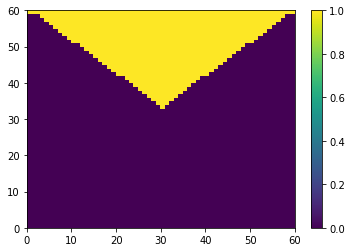

In [5]:
n = int(len_m*scalef)
vals = getStreamFuncVals(n)

#convert vals to a square matrix for visualization
vals_sq = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        vals_sq[i][j] = vals[j*n+i]
        
plt.pcolor(vals_sq)
plt.colorbar()

Calculate the streamfunction

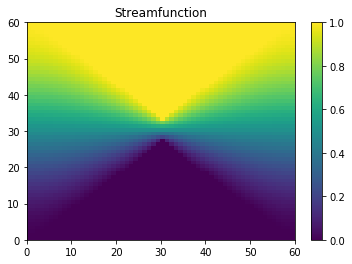

In [6]:
n = int(len_m*scalef)

#calculate streamfunction
coeffs = streamfuncCoeffsMatrix(n,1,1)
vals = getStreamFuncVals(n)

func = linalg.solve(coeffs, vals)

stream = np.zeros((n,n))
stream_graph = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        stream[i][j] = func[i*n+j]
        stream_graph[i][j] = func[j*n+i]

# plt.pcolor(stream, vmin = -1, vmax = 1)
plt.pcolor(stream_graph)
plt.title("Streamfunction")
plt.colorbar()

Define the x and y derivatives of the streamfunction

In [7]:
#Params
#psi - streamfunction
#dx - change in x
#i - x value
#j - y value
#returns- approximation of d(psi)/dx
def dPsi_dx(psi, dx, i, j):
    return (psi[i+1][j]-psi[i-1][j])/2/dx

#Params
#psi - streamfunction
#dy - change in y
#i - x value
#j - y value
#returns- approximation of d(psi)/dy
def dPsi_dy(psi, dy, i, j):
    return (psi[i][j+1]-psi[i][j-1])/2/dy

Plot the velocities in the x and y directions based on the streamfunction. vel_x = dPsi/dy, vel_y = - dPsi/dx

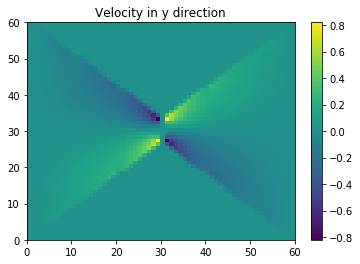

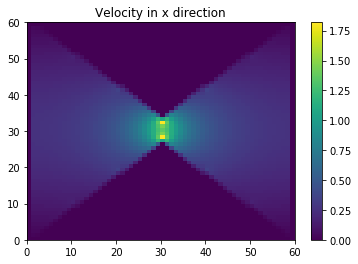

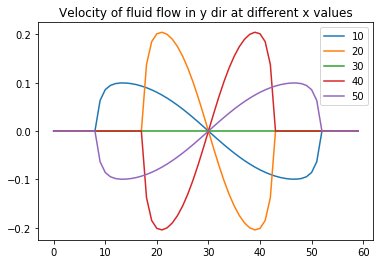

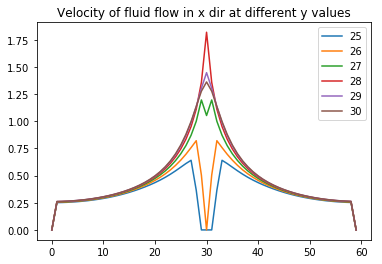

In [8]:
u = np.zeros((n,n))
v = np.zeros((n,n))

#pcolor graphs seem to plot the x values on the vertical axis so I manualy flipped these for visualization purposes
u_graph = np.zeros((n,n))
v_graph = np.zeros((n,n))

for i in range(1,n-1):
    for j in range(1,n-1):
        u[i][j] = dPsi_dy(stream, .1, i, j)
        v[i][j] = -dPsi_dx(stream, .1, i, j)
        u_graph[i][j] = dPsi_dx(stream_graph, .1, i, j)
        v_graph[i][j] = -dPsi_dy(stream_graph, .1, i, j)
    
plt.pcolor(v_graph)
plt.colorbar()
plt.title("Velocity in y direction")
plt.show()

plt.pcolor(u_graph)
plt.colorbar()
plt.title("Velocity in x direction")
plt.show()

for j in range(5):
    vels = [v[10+j*10][i] for i in range(n)]
    label = (10+j*10)
    plt.plot(vels, label=label)
    
plt.legend()
plt.title("Velocity of fluid flow in y dir at different x values")
plt.show()


for j in range(6):
    vels = [u[i][25+j*1] for i in range(n)]
    label = (25+j*1)
    plt.plot(vels, label=label)
    
plt.legend()
plt.title("Velocity of fluid flow in x dir at different y values")
plt.show()

Calculate the velocity for any point in the field by averaging values from the velocity grid

In [9]:
#Parameters
# x: x position
# y: y position
# u: vel field in x dir
# v: vel field in y dir
#dx: step in x dir
#dy: step in y dir
#returns: vel in x and y dirs at (x,y)
def getVelGrid(x, y, u, v, dx, dy):
    grid = np.zeros((len(u), len(u),2))
    for i in range(len(u)):
        for j in range(len(u)):
            grid[i][j] = [i*dx, j*dy]
         
    #find indicies in the grid on each side of the given (x,y) position
    left = math.floor(x/dx)
    right = math.ceil(x/dx)
    top = math.ceil(y/dy)
    bottom = math.floor(y/dy)
    
    #TODO
    if (left == right):
        right = (right + 1)
    if (bottom == top):
        top = (top + 1) 
    
    #use a weighted average of neighboring grid points to solve for the velocity at (x,y)
    xvel = (u[left][bottom] * (dx-abs(x-grid[left][bottom][0]))/dy + u[left][top] * (dx-abs(x-grid[left][top][0]))/dy 
            + u[right][bottom] * (dx-abs(x-grid[right][bottom][0]))/dy + u[right][top] * (dx-abs(x-grid[right][top][0]))/dy)/4
    
    yvel = (v[left][bottom] * (dy-abs(y-grid[left][bottom][1]))/dy + v[left][top] * (dy-abs(y-grid[left][top][1]))/dy
            + v[right][bottom] * (dy-abs(y-grid[right][bottom][1]))/dy + v[right][top] * (dy-abs(y-grid[right][top][1]))/dy)/4

    return (xvel, yvel)

This can actually be done with scipy's interpolation method https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html

In [10]:
#Parameters
# u: vel field in x dir
# v: vel field in y dir
#dx: step in x dir
#dy: step in y dir
#returns: vel functions in x and y dirs
def interpolateVelFn(u, v, dx, dy):
    n = len(u)
    x = np.arange(0, n, 1)
    y = np.arange(0, n, 1)
    
    velX = interpolate.interp2d(x, y, u.flatten(), kind='cubic')
    velY = interpolate.interp2d(x, y, v.flatten(), kind='cubic')
    
    return velX, velY

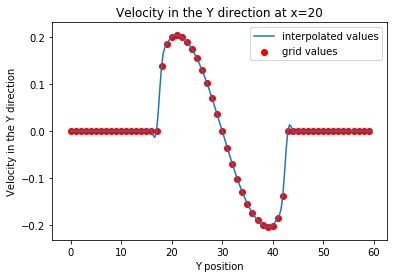

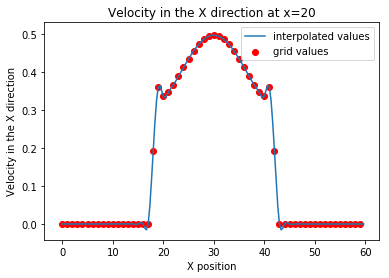

In [11]:
velX, velY = interpolateVelFn(u, v, len_m/n, len_m/n)    

#calculate the y velocity at a range of points
yvels_20 = [velY(20, i/3) for i in range(n*3)]
yvals = [i/3 for i in range(n*3)]

plt.plot(yvals, yvels_20, label="interpolated values")
plt.scatter(np.arange(0,n,1), v[20,:], label="grid values", color='red')
plt.title("Velocity in the Y direction at x=20")
plt.xlabel("Y position")
plt.ylabel("Velocity in the Y direction")
plt.legend()
plt.show()

#calculate the x velocity at a range of points
xvels_20 = [velX(20, i/3) for i in range(n*3)]
xvals = [i/3 for i in range(n*3)]

plt.plot(xvals, xvels_20, label="interpolated values")
plt.scatter(np.arange(0,n,1), u[20,:], label="grid values", color='red')
plt.title("Velocity in the X direction at x=20")
plt.xlabel("X position")
plt.ylabel("Velocity in the X direction")
plt.legend()
plt.show()

Graph the velocity field

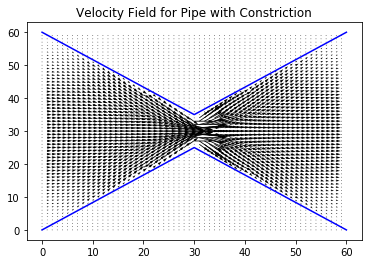

In [12]:
import matplotlib.cm as cm

X = np.zeros((60,60))
Y = np.zeros((60,60))

for i in range(60):
    for j in range(60):
        X[i][j] = i
        Y[i][j] = j

plt.quiver(X, Y, u, v, headaxislength=6)
plt.title("Velocity Field for Pipe with Constriction")

plt.plot((0, 30, 60), (60, 35, 60), c="blue")
plt.plot((0, 30, 60), (0, 25, 0), c="blue")
# plt.colorbar()

## Run Simulation

### Calculate the forces on a particle

In [13]:
#Calculate the forces from a collision between 2 particles
#R - radius
#xi, yi - position of particle 1
#vxi, vyi - velocity of particle 1
#xj, yj - position of particle 2
#vxj, vyj - velocity of particle 2
#returns - the force on particle i in the x and y directions and the potential
def calcCollision(R, xi, yi, vxi, vyi, xj, yj, vxj, vyj):

    distance = math.sqrt((xi-xj)**2+(yi-yj)**2)
    rij = (xi-xj, yi-yj)
    unit = unitVec(rij)

    #calculate potential
    Vij = 4*E/(3*(1-poisson)**2) * math.sqrt(R/2) * ((1-distance/(2*R))**alpha)
    dVdr = 4*E/(3*(1-poisson)**2) * math.sqrt(R/2) * (-alpha/2/R) * (1-distance/(2*R))**(alpha-1)  
    Fx = - dVdr * unit[0]
    Fy = - dVdr * unit[1]

    return Fx, Fy, Vij

#calculate the force on a particle from the fluid
#x, y - position of particle
#vx, vy - velocity of particle
#u, v - the functions for calculating the velocity an the x and y directions
#returns - force of the fluid in x and y directions
def calcFluidForce(x, y, vx, vy, u, v):
    #force due to fluid flow
    uvel = u(x, y)
    vvel = v(x, y)
    beta = 6 * math.pi * dyn_vis * R

    Fx_fluid = beta * (uvel - vx)
    Fy_fluid = beta * (vvel - vy)
    
    return Fx_fluid, Fy_fluid

#Same as above but nondimentinalized, includes nondim constants tau and eta
def calcFluidForceNonDim(x, y, vx, vy, u, v, tau, eta):
    #force due to fluid flow
    uvel = u(x, y)
    vvel = v(x, y)
    beta = 6 * math.pi * dyn_vis * R

    Fx_fluid = beta * (uvel * tau**2 /eta /mass - vx * tau / mass)
    Fy_fluid = beta * (vvel * tau**2 /eta /mass - vy * tau / mass)
    
    return Fx_fluid, Fy_fluid

#Calculate the potential as the particle approaches a wall
#x, y - position of particle
#slope - slope of the wall
#tau, eta - nondimentionalization constants
#returns - forces in the x and y directions
def calcPotentialWall(x, y, slope, tau, eta):
    a = 50
    V = (math.e ** (-a*(y-x*slope)) + math.e **(a*(y-(len_m*scalef-x*slope)))) * tau**2/eta/mass
    Fx = -a*slope*V
    Fy=  a*(math.e ** (-a*(y-x*slope)) - math.e **(a*(y-(len_m*scalef-x*slope)))) * tau**2/eta/mass
    return Fx, Fy

Misc geometry helper functions

In [14]:
#returns a unit vector in the same dir as some 2d vector v
def unitVec(v):
    v_mag = math.sqrt(v[0]**2 + v[1]**2)
    if (v_mag > 0):
        v_unit = (v[0]/v_mag, v[1]/v_mag)
    else:
        v_unit = (0, 0)
    return v_unit

Plot the force of the wall as a function of y, calculated using the wall potential function

Text(0,0.5,'Force')

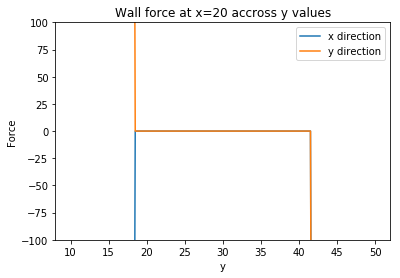

In [15]:
x = np.linspace(10,50,100)
fx, fy = calcPotentialWall(20, x, slope, 1, 1)

plt.plot(x, fx, label="x direction")
plt.plot(x, fy, label = "y direction")
plt.legend()
plt.ylim(-100,100)
plt.title("Wall force at x=20 accross y values")
plt.xlabel("y")
plt.ylabel("Force")

Step the simulation: Calculate the derivatives at a given point

In [16]:
#Parameters
#t - timestep
#pos - array of the form (x0, y0, vx0, vy0, x1, ...)
#num_parts - total # particles in simulation
#R - radius of particle
#energy - 1d array to document the energy values at each step
#forces - array to document forces at each step
#         of the form: forces[i] = [[Fx_fluid, Fy_fluid], [Fx_wall, Fy_wall], [Fx_col, Fy_col]]
#vVel, yVel - the functions for calculating the velocity at a certain position
#
#Returns: derivatives of each value of the position array
#         [x0', y0', x0'', y0'', x1'...]
def stepODE(t, pos, num_parts, R, energy, forces, times, derivs, xVel, yVel):
    
    ddt = []
    V_col = 0
    times.append(t)
        
    for i in range(num_parts):
        x = pos[i*4]
        y = pos[i*4+1]
        vx = pos[i*4+2]
        vy = pos[i*4+3]
        
        #force due to fluid flow
        Fx_fluid, Fy_fluid = calcFluidForceNonDim(x, y, vx, vy, xVel, yVel, tau, eta)
        
        #force due to collisions
        Fx_col = 0
        Fy_col = 0
        for j in range(num_parts):
            if j != i:
                distance = math.sqrt((x-pos[j*4])**2 + (y-pos[j*4+1])**2)

                #if the particles overlap
                if (distance < 2*R):
                    xj = pos[j*4]
                    yj = pos[j*4+1]
                    vxj = pos[j*4+2]
                    vyj = pos[j*4+3]

                    Fx, Fy, V = calcCollision(R, x, y, vx, vy, xj, yj, vxj, vyj)
                    Fx_col += Fx
                    Fy_col += Fy
                    V_col += V
                    
        #force from wall potential
        wallX = 0
        wallY = 0
        if (x <= length*scalef/2):
            
            #calculate the point on the edge of the particle which is closest to the wall
            #the edge of the particle is what matters, not the center
            #this is a vector parpendicular to the wall 
            if (y <= len_m/2*scalef):
                direction = unitVec((-1, 1/slope)) 
            else:
                direction = unitVec((-1, -1/slope))
            wallX, wallY = calcPotentialWall(x - direction[0]*R, y - direction[1]*R, slope, tau, eta)
            
        #document forces
        if i == 0:
            forces.append([[Fx_fluid, Fy_fluid], [wallX, wallY], [Fx_col*tau**2/eta/mass, Fy_col*tau**2/eta/mass]])
        
        #Nondimentionalized:
        Fx_net = Fx_fluid + wallX + (Fx_col * tau**2 / eta / mass)
        Fy_net = Fy_fluid + wallY + (Fy_col* tau**2 /eta/mass)
        ddt = ddt + [vx*eta/tau, vy*eta/tau, Fx_net, Fy_net]
        
    derivs.append(ddt)
        
    energy.append(V_col)
    return ddt

Run a simulation. Sets up and moniters the solver

In [17]:
#Params
#num_parts - number of particles
#r - radius of particle
#dt - timestep
#tf - end time
#pos0 - inital positions/velocities
#returns - y - postiions over time
#          energy - energy at each timestep
#          forces - forces at each timestep
#          times - time at each iteration
#          derives - derivatives at each timestep
def runSim(num_parts, r, dt, tf, pos0):

    energy = []
    forces = []
    times = []
    derivs = []
    xvel, yvel = interpolateVelFn(u, v, 1, 1)

    solver = ode(stepODE).set_integrator('lsoda')
    solver.set_initial_value(pos0, 0).set_f_params(num_parts, r, energy, forces, times, derivs, xvel, yvel)
    y, t = [pos0], []
    while solver.successful() and solver.t < tf:
        t.append(solver.t)
        out = solver.integrate(solver.t+dt)
        y = np.concatenate((y, [out]), axis=0)

    print(solver.get_return_code())
    
    return y, energy, forces, times, derivs

Animate the trajectories of the particles

In [18]:
%matplotlib inline

def generateAnim(y, num_parts, r):
    xmax = length*scalef
    ymax = len_m*scalef
    num_steps = len_m*scalef
    X = np.linspace(0, xmax, num_steps)
    Y = np.linspace(0, ymax, num_steps)

    print(xmax, ymax)

    #initialize figure and create a scatterplot
    fig, ax = plt.subplots()
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
    plt.pcolor(X, Y, u_graph)
    plt.colorbar()
    plt.gca().set_aspect('equal', adjustable='box')

    plt.plot((0, 30, 60), (60, 35, 60), c="blue")
    plt.plot((0, 30, 60), (0, 25, 0), c="blue")

    circles = []
    for i in range(num_parts):
        circles.append(Circle((y[:,0+i*4],y[:,1+i*4]), r, color="white", fill=False))
        ax.add_artist(circles[i])

    positions = []
    for i in range(num_parts):
        positions.append((y[:,0+i*4][0], y[:,1+i*4][0]))

    def updateParticles_2(timestep):

        positions = []
        for i in range(num_parts):
            positions.append((y[:,0 + i*4][int(timestep)*5], y[:,1+i*4][int(timestep)*5]))
            circles[i].center = positions[-1]

        return circles,

    #create the animation    
    ani = animation.FuncAnimation(fig, updateParticles_2, frames=int(len(y[:,0]-1)/5), interval=50)
    
    return ani

## Visualize the Results

Run a simulation

C:\Users\abbyw\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
C:\Users\abbyw\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
MovieWriter imagemagick unavailable.


2
60.0 60.0


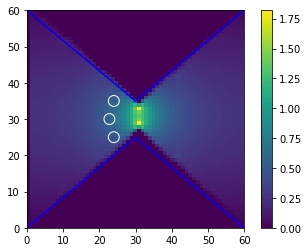

In [19]:
%matplotlib inline

#format: x_i, y_i, vx_i, vy_i, x_i+1...
pos0 = []
num_parts = 3
for j in range(num_parts):
    if j == 1:
        x = 22.785
    else:
        x = 24
    pos0 = pos0 + [x, 25 + j*5, 0, 0]
    
r = 1.5
trajectory, energy, forces, t, der = runSim(num_parts, r, 0.1, 25, pos0)

ani = generateAnim(trajectory, num_parts, r)

ani.save('clog.032620.gif', writer='imagemagick')

HTML(ani.to_jshtml())

Plot the forces from differnt sources (fluid flow, the wall, collisions) as a function of time

(-1, 1)

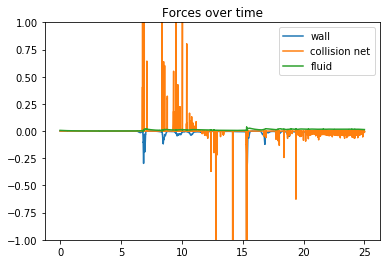

In [32]:
fcx = []
fwx = []
ffx = []

for i in range(len(forces)):
    fcx.append(forces[i][2][0])
    fwx.append(forces[i][1][0])
    ffx.append(forces[i][0][0])

plt.plot(t, fwx, label="wall")
plt.plot(t, fcx, label="collision net")
plt.plot(t, ffx, label="fluid")
plt.legend()
plt.title("Forces over time")
plt.ylim(-1,1)

Plot the total energy of the system over time

(0, 1)

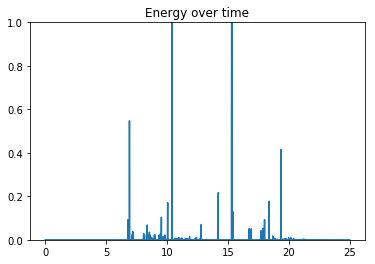

In [34]:
plt.plot(t, energy)
plt.title("Energy over time")
plt.ylim(0,1)

2
60.0 60.0


C:\Users\abbyw\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
C:\Users\abbyw\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


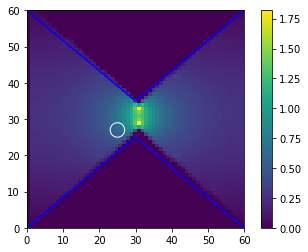

In [248]:
%matplotlib inline

#format: x_i, y_i, vx_i, vy_i, x_i+1...
pos0 = []
num_parts = 1
for i in range(num_parts):
    if i == 1:
        x = 23
    else:
        x = 25
    pos0 = pos0 + [x, 27+ 5*i, -0.01,0.01]
    
num_particles = 1
r = 2
trajectory, energy, forces, t, der = runSim(num_particles, r, 0.1, 30, pos0)

ani = generateAnim(trajectory, num_particles, r)
HTML(ani.to_jshtml())

Text(0.5,1,'Forces over time')

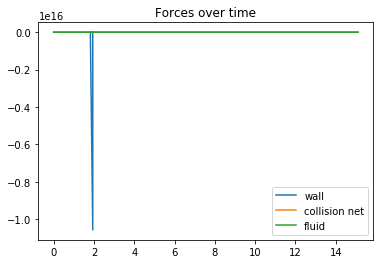

In [109]:
fcx = []
fwx = []
ffx = []

for i in range(len(forces)):
    fcx.append(forces[i][2][0])
    fwx.append(forces[i][1][0])
    ffx.append(forces[i][0][0])

plt.plot(t, fwx, label="wall")
plt.plot(t, fcx, label="collision net")
plt.plot(t, ffx, label="fluid")
plt.legend()
plt.title("Forces over time")
# plt.ylim(-1,1)

Plot streamlines of particles in the fluid flow

### Testing: trajectories of individual particles at various points

2
2
2


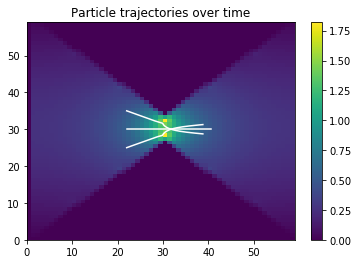

In [115]:
R = 1
trajectory1, energy1, forces1, times1, d1 = runSim(1, R, 0.1, 50, [22,25,1e-8,1e-8])
trajectory2, energy2, forces2, times2, d2 = runSim(1, R, 0.1, 50, [22,30,0,0])
trajectory3, energy3, forces3, times3, d3 = runSim(1, R, 0.1, 50, [22,35,1e-8,1e-8])

#initialize figure and create a scatterplot
fig, ax = plt.subplots()
plt.pcolor(Y, X, u_graph)
plt.colorbar()

plt.plot(trajectory1[:,0], trajectory1[:,1], color="white")
plt.plot(trajectory2[:,0], trajectory2[:,1], color="white")
plt.plot(trajectory3[:,0], trajectory3[:,1], color="white")
    
plt.title("Particle trajectories over time")
plt.show()

Text(0.5,1,'Time vs Step Number')

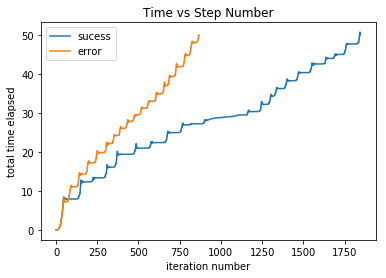

In [138]:
plt.plot(times1, label="sucess")
plt.plot(times2, label="error")
plt.legend()
plt.xlabel("iteration number")
plt.ylabel("total time elapsed")
plt.title("Time vs Step Number")

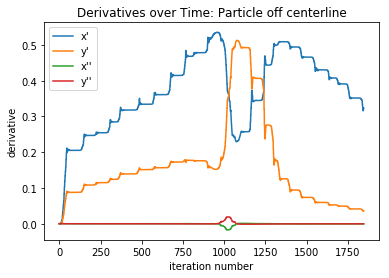

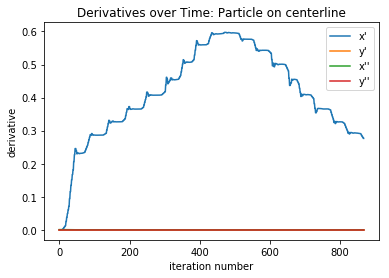

In [139]:
plt.plot([row[0] for row in d1], label="x'")
plt.plot([row[1] for row in d1], label="y'")
plt.plot([row[2] for row in d1], label="x''")
plt.plot([row[3] for row in d1], label="y''")
plt.legend()
plt.xlabel("iteration number")
plt.ylabel("derivative")
plt.title("Derivatives over Time: Particle off centerline")
plt.show()

plt.plot([row[0] for row in d2], label="x'")
plt.plot([row[1] for row in d2], label="y'")
plt.plot([row[2] for row in d2], label="x''")
plt.plot([row[3] for row in d2], label="y''")
plt.legend()
plt.xlabel("iteration number")
plt.ylabel("derivative")
plt.title("Derivatives over Time: Particle on centerline")
plt.show()

These graphs show that particles on and off the centerline now both have successful models. Previously, the particle on the centerline would throw an error, but this bug has been resolved and both now have reasonable timesteps and derivatives

Text(0.5,1,'Forces over time')

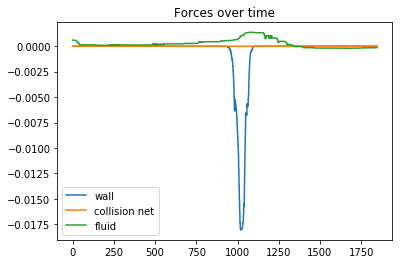

In [119]:
fcx = []
fwx = []
ffx = []

for i in range(len(forces1)):
    fcx.append(forces1[i][2][0])
    fwx.append(forces1[i][1][0])
    ffx.append(forces1[i][0][0])

plt.plot(fwx, label="wall")
plt.plot(fcx, label="collision net")
plt.plot(ffx, label="fluid")
plt.legend()
plt.title("Forces over time")
# plt.ylim(-1,1)